In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import re
import math
import datetime
import random
import copy
from tqdm import tqdm

#from sklearn.preprocessing import LabelEncoder
#from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
#import train and test datasets
train1 = pd.read_csv('/home/felix/Downloads/zimnat/Train.csv', parse_dates = ['join_date'])
test1 = pd.read_csv('/home/felix/Downloads/zimnat/Test.csv', parse_dates=['join_date'])
submission = pd.read_csv('/home/felix/Downloads/zimnat/SampleSubmission.csv')

In [3]:
train1.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,4WKQSBB,2019-01-02,F,M,1987,1X1H,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,CP5S02H,2019-01-06,F,M,1981,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2YKDILJ,2013-01-06,M,U,1991,748L,QZYX,90QI,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2S9E81J,2019-01-08,M,M,1990,1X1H,BP09,56SI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,BHDYVFT,2019-01-08,M,M,1990,748L,NO3L,T4MS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [4]:
test1.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,F86J5PC,2018-01-12,M,M,1984,94KC,DZRV,90QI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,H6141K3,2019-01-10,M,M,1996,1X1H,J9SY,90QI,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,RBAYUXZ,2020-01-01,F,W,1968,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,KCBILBQ,2019-01-02,M,M,1989,94KC,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,LSEC1ZJ,2020-01-02,F,M,1982,UAOD,0KID,T4MS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [5]:
# Split features and labels
train1_labels = train1[['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']].reset_index(drop=True)
train1_features = train1.drop(columns=['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3'], axis=1)
test1_features = test1.drop(columns=['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3'], axis=1)
test1_labels = test1[['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']].reset_index(drop=True)

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train1_features, test1_features]).reset_index(drop=True)
print(all_features.shape, train1_labels.shape)

(39132, 8) (29132, 21)


In [6]:
# determine the threshold for missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:9]

Percent of missing data


[('join_date', 0.01),
 ('ID', 0.0),
 ('sex', 0.0),
 ('marital_status', 0.0),
 ('birth_year', 0.0),
 ('branch_code', 0.0),
 ('occupation_code', 0.0),
 ('occupation_category_code', 0.0)]

In [7]:
def handl_miss(df):
    df['join_date'] = df.groupby('branch_code')['join_date'].transform(lambda x: x.fillna(x.mode()[0]))
    return df


all_features = handl_miss(all_features)    

In [8]:
# Let's make sure we handled all the missing values
missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('ID', 0.0),
 ('join_date', 0.0),
 ('sex', 0.0),
 ('marital_status', 0.0),
 ('birth_year', 0.0),
 ('branch_code', 0.0),
 ('occupation_code', 0.0),
 ('occupation_category_code', 0.0)]

In [9]:
all_features.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code
0,4WKQSBB,2019-01-02,F,M,1987,1X1H,2A7I,T4MS
1,CP5S02H,2019-01-06,F,M,1981,UAOD,2A7I,T4MS
2,2YKDILJ,2013-01-06,M,U,1991,748L,QZYX,90QI
3,2S9E81J,2019-01-08,M,M,1990,1X1H,BP09,56SI
4,BHDYVFT,2019-01-08,M,M,1990,748L,NO3L,T4MS


In [10]:
all_features['age'] = 2020 - all_features['birth_year']
all_features['join_year'] = all_features['join_date'].dt.year
all_features['join_month'] = all_features['join_date'].dt.month
all_features['join_day'] = all_features['join_date'].dt.day

dt = pd.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
all_features['time_period'] = dt - all_features['join_date']

all_features['ageWJ'] = all_features['join_date'].dt.year - all_features['birth_year']
all_features['year_num'] = 2020 - all_features['join_year']

all_features['time_period'] = all_features['time_period'].astype(str)
all_features['time_period'] = all_features['time_period'].str.extract('(\d+)').astype(int)
all_features['yr_0'] = all_features['time_period'] / 365

In [11]:
all_features.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0
0,4WKQSBB,2019-01-02,F,M,1987,1X1H,2A7I,T4MS,33,2019,1,2,600,32,1,1.643836
1,CP5S02H,2019-01-06,F,M,1981,UAOD,2A7I,T4MS,39,2019,1,6,596,38,1,1.632877
2,2YKDILJ,2013-01-06,M,U,1991,748L,QZYX,90QI,29,2013,1,6,2787,22,7,7.635616
3,2S9E81J,2019-01-08,M,M,1990,1X1H,BP09,56SI,30,2019,1,8,594,29,1,1.627397
4,BHDYVFT,2019-01-08,M,M,1990,748L,NO3L,T4MS,30,2019,1,8,594,29,1,1.627397


In [12]:
def logs(res, ls):
    m =res.shape[1]
    for l in ls:
        res = res.assign(newcol = pd.Series(np.log(1.01+res[l])).values)
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['birth_year', 'age', 'ageWJ']

all_features = logs(all_features, log_features)

In [13]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)
        res.columns.values[m] = l + '_sq'
        m += 1
    return res

squared_features = ['birth_year', 'age', 'ageWJ']
all_features = squares(all_features, squared_features)

In [14]:
all_features.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0,birth_year_log,age_log,ageWJ_log,birth_year_sq,age_sq,ageWJ_sq
0,4WKQSBB,2019-01-02,F,M,1987,1X1H,2A7I,T4MS,33,2019,1,2,600,32,1,1.643836,7.594889,3.526655,3.496811,3948169,1089,1024
1,CP5S02H,2019-01-06,F,M,1981,UAOD,2A7I,T4MS,39,2019,1,6,596,38,1,1.632877,7.591867,3.689129,3.663818,3924361,1521,1444
2,2YKDILJ,2013-01-06,M,U,1991,748L,QZYX,90QI,29,2013,1,6,2787,22,7,7.635616,7.596899,3.401531,3.135929,3964081,841,484
3,2S9E81J,2019-01-08,M,M,1990,1X1H,BP09,56SI,30,2019,1,8,594,29,1,1.627397,7.596397,3.434310,3.401531,3960100,900,841
4,BHDYVFT,2019-01-08,M,M,1990,748L,NO3L,T4MS,30,2019,1,8,594,29,1,1.627397,7.596397,3.434310,3.401531,3960100,900,841


In [15]:
all_features = all_features.loc[:, ~all_features.columns.duplicated()]

In [16]:
X_train__ = all_features.iloc[:len(train1_labels), :]
X_test__ = all_features.iloc[len(train1_labels):, :]
X_train__.shape, train1_labels.shape, X_test__.shape, test1_labels.shape

((29132, 22), (29132, 21), (10000, 22), (10000, 21))

In [17]:
train = pd.concat([X_train__, train1_labels], axis=1)

In [18]:
X_test__ = X_test__.reset_index(drop=True)
test = pd.concat([X_test__, test1_labels], axis=1)

In [19]:
print(train.shape, test.shape)

(29132, 43) (10000, 43)


In [20]:
train.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0,birth_year_log,age_log,ageWJ_log,birth_year_sq,age_sq,ageWJ_sq,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,4WKQSBB,2019-01-02,F,M,1987,1X1H,2A7I,T4MS,33,2019,1,2,600,32,1,1.643836,7.594889,3.526655,3.496811,3948169,1089,1024,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,CP5S02H,2019-01-06,F,M,1981,UAOD,2A7I,T4MS,39,2019,1,6,596,38,1,1.632877,7.591867,3.689129,3.663818,3924361,1521,1444,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2YKDILJ,2013-01-06,M,U,1991,748L,QZYX,90QI,29,2013,1,6,2787,22,7,7.635616,7.596899,3.401531,3.135929,3964081,841,484,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2S9E81J,2019-01-08,M,M,1990,1X1H,BP09,56SI,30,2019,1,8,594,29,1,1.627397,7.596397,3.434310,3.401531,3960100,900,841,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,BHDYVFT,2019-01-08,M,M,1990,748L,NO3L,T4MS,30,2019,1,8,594,29,1,1.627397,7.596397,3.434310,3.401531,3960100,900,841,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [21]:
#print all dataset shape
print(train.shape, test.shape,submission.shape)

(29132, 43) (10000, 43) (210000, 2)


In [22]:
#Store Products ID in Multidimensional array
products =train[['P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']]
products_t =test[['P5DA', 'RIBP', '8NN1',
       '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO',
       'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']]

In [23]:
#Axis Transformation
train = train.melt(id_vars=train.columns[:22], value_vars=products, var_name = "PCODE", value_name="Label" )
test = test.melt(id_vars=test.columns[:22], value_vars=products_t, var_name = "PCODE", value_name="Label" )

In [24]:
print(train.shape, test.shape, submission.shape)

(611772, 24) (210000, 24) (210000, 2)


In [25]:
#Concatenate new column towards submission requirement
train['ID X PCODE'] = train['ID'] + ' X ' + train['PCODE']
test['ID X PCODE'] = test['ID'] + ' X ' + test['PCODE']

In [26]:
train.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0,birth_year_log,age_log,ageWJ_log,birth_year_sq,age_sq,ageWJ_sq,PCODE,Label,ID X PCODE
0,4WKQSBB,2019-01-02,F,M,1987,1X1H,2A7I,T4MS,33,2019,1,2,600,32,1,1.643836,7.594889,3.526655,3.496811,3948169,1089,1024,P5DA,0,4WKQSBB X P5DA
1,CP5S02H,2019-01-06,F,M,1981,UAOD,2A7I,T4MS,39,2019,1,6,596,38,1,1.632877,7.591867,3.689129,3.663818,3924361,1521,1444,P5DA,0,CP5S02H X P5DA
2,2YKDILJ,2013-01-06,M,U,1991,748L,QZYX,90QI,29,2013,1,6,2787,22,7,7.635616,7.596899,3.401531,3.135929,3964081,841,484,P5DA,0,2YKDILJ X P5DA
3,2S9E81J,2019-01-08,M,M,1990,1X1H,BP09,56SI,30,2019,1,8,594,29,1,1.627397,7.596397,3.434310,3.401531,3960100,900,841,P5DA,0,2S9E81J X P5DA
4,BHDYVFT,2019-01-08,M,M,1990,748L,NO3L,T4MS,30,2019,1,8,594,29,1,1.627397,7.596397,3.434310,3.401531,3960100,900,841,P5DA,0,BHDYVFT X P5DA


In [27]:
train.columns

Index(['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'branch_code', 'occupation_code', 'occupation_category_code', 'age', 'join_year', 'join_month', 'join_day', 'time_period', 'ageWJ', 'year_num', 'yr_0', 'birth_year_log', 'age_log', 'ageWJ_log', 'birth_year_sq', 'age_sq', 'ageWJ_sq', 'PCODE', 'Label', 'ID X PCODE'], dtype='object')

In [28]:
#Re-arrange column (not necessary)
train=train[['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'age', 'join_year', 'join_month', 'join_day', 'time_period', 'ageWJ', 'year_num', 'yr_0', 'birth_year_log', 'age_log', 'ageWJ_log', 'birth_year_sq', 'age_sq', 'ageWJ_sq', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE','ID X PCODE',  'Label']]
test=test[['ID', 'join_date', 'sex', 'marital_status', 'birth_year', 'age', 'join_year', 'join_month', 'join_day', 'time_period', 'ageWJ', 'year_num', 'yr_0', 'birth_year_log', 'age_log', 'ageWJ_log', 'birth_year_sq', 'age_sq', 'ageWJ_sq', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE','ID X PCODE']]


train = train.drop(columns=['join_date'], axis=1)
test = test.drop(columns=['join_date'], axis=1)

In [29]:
train.head()

,ID,sex,marital_status,birth_year,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0,birth_year_log,age_log,ageWJ_log,birth_year_sq,age_sq,ageWJ_sq,branch_code,occupation_code,occupation_category_code,PCODE,ID X PCODE,Label
0,4WKQSBB,F,M,1987,33,2019,1,2,600,32,1,1.643836,7.594889,3.526655,3.496811,3948169,1089,1024,1X1H,2A7I,T4MS,P5DA,4WKQSBB X P5DA,0
1,CP5S02H,F,M,1981,39,2019,1,6,596,38,1,1.632877,7.591867,3.689129,3.663818,3924361,1521,1444,UAOD,2A7I,T4MS,P5DA,CP5S02H X P5DA,0
2,2YKDILJ,M,U,1991,29,2013,1,6,2787,22,7,7.635616,7.596899,3.401531,3.135929,3964081,841,484,748L,QZYX,90QI,P5DA,2YKDILJ X P5DA,0
3,2S9E81J,M,M,1990,30,2019,1,8,594,29,1,1.627397,7.596397,3.434310,3.401531,3960100,900,841,1X1H,BP09,56SI,P5DA,2S9E81J X P5DA,0
4,BHDYVFT,M,M,1990,30,2019,1,8,594,29,1,1.627397,7.596397,3.434310,3.401531,3960100,900,841,748L,NO3L,T4MS,P5DA,BHDYVFT X P5DA,0


In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611772 entries, 0 to 611771
Data columns (total 24 columns):
ID                          611772 non-null object
sex                         611772 non-null object
marital_status              611772 non-null object
birth_year                  611772 non-null int64
age                         611772 non-null int64
join_year                   611772 non-null int64
join_month                  611772 non-null int64
join_day                    611772 non-null int64
time_period                 611772 non-null int64
ageWJ                       611772 non-null int64
year_num                    611772 non-null int64
yr_0                        611772 non-null float64
birth_year_log              611772 non-null float64
age_log                     611772 non-null float64
ageWJ_log                   611772 non-null float64
birth_year_sq               611772 non-null int64
age_sq                      611772 non-null int64
ageWJ_sq                    

 ENCODE CATEGORICAL FEATURES

In [47]:
# encode categorical variables
from sklearn.preprocessing import OneHotEncoder
ohc = OneHotEncoder()
ohe = ohc.fit_transform(train.sex.values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(ohe, columns=['sex'+str(ohc.categories_[0][i]) for i in range(len(ohc.categories_[0]))])

train = pd.concat([train, dfOneHot], axis=1)
train.head()

,ID,sex,marital_status,birth_year,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0,birth_year_log,age_log,ageWJ_log,birth_year_sq,age_sq,ageWJ_sq,branch_code,occupation_code,occupation_category_code,PCODE,ID X PCODE,Label,sexF,sexM
0,4WKQSBB,F,M,1987,33,2019,1,2,600,32,1,1.643836,7.594889,3.526655,3.496811,3948169,1089,1024,1X1H,2A7I,T4MS,P5DA,4WKQSBB X P5DA,0,1.0,0.0
1,CP5S02H,F,M,1981,39,2019,1,6,596,38,1,1.632877,7.591867,3.689129,3.663818,3924361,1521,1444,UAOD,2A7I,T4MS,P5DA,CP5S02H X P5DA,0,1.0,0.0
2,2YKDILJ,M,U,1991,29,2013,1,6,2787,22,7,7.635616,7.596899,3.401531,3.135929,3964081,841,484,748L,QZYX,90QI,P5DA,2YKDILJ X P5DA,0,0.0,1.0
3,2S9E81J,M,M,1990,30,2019,1,8,594,29,1,1.627397,7.596397,3.434310,3.401531,3960100,900,841,1X1H,BP09,56SI,P5DA,2S9E81J X P5DA,0,0.0,1.0
4,BHDYVFT,M,M,1990,30,2019,1,8,594,29,1,1.627397,7.596397,3.434310,3.401531,3960100,900,841,748L,NO3L,T4MS,P5DA,BHDYVFT X P5DA,0,0.0,1.0


In [52]:
#WOE
woe_df = train.groupby('sex')['Label'].mean()
woe_df = pd.DataFrame(woe_df)
woe_df = woe_df.rename(columns = {'Label':'Good'})
woe_df['Bad'] = 1-woe_df.Good
woe_df['Bad'] = np.where(woe_df['Bad'] == 0, 0.000001, woe_df['Bad'])
woe_df['WoE'] = np.log(woe_df.Good/woe_df.Bad)
woe_df


train.loc[:, 'WoE_Encode'] = train['sex'].map(woe_df['WoE'])

In [53]:
#PRE
pr_df = train.groupby('sex')['Label'].mean()
pr_df = pd.DataFrame(pr_df)
pr_df = pr_df.rename(columns = {'Label':'Good'})
pr_df['Bad'] = 1-pr_df.Good
pr_df['Bad'] = np.where(pr_df['Bad'] == 0, 0.000001, pr_df['Bad'])
pr_df['PR'] = pr_df.Good/pr_df.Bad
pr_df


train.loc[:, 'Pr_Encode'] = train['sex'].map(pr_df['PR'])

In [54]:
#mean
mean = train['Label'].mean()
agg = train.groupby('sex')['Label'].agg(['count', 'mean'])
counts = agg['count']
means = agg['mean']
weight = 100
smooth = (counts * means + weight * mean) / (counts + weight)
print(smooth)
train.loc[:, 'sex_smean_enc'] = train['sex'].map(smooth)

sex
F    0.108226
M    0.108562
dtype: float64


In [55]:
#binary
import category_encoders as ce
bin_enc = ce.BinaryEncoder(cols=['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
dfbin = encoder.fit_transform(df['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
df = pd.concat([df, dfbin], axis=1)

ModuleNotFoundError: No module named 'category_encoders'

In [ ]:
#leaveoneout
loo_enc = ce.LeaveOneOutEncoder(cols=['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
dfloo = encoder.fit_transform(df['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
df = pd.concat([df, dfbin], axis=1)
df

In [ ]:
#james-stein
js_enc = ce.JamesSteinEncoder(cols=['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
dfjs = encoder.fit_transform(df['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
df = pd.concat([df, dfbin], axis=1)
df

In [ ]:
#m-estimate
me_enc = ce.MEstimateEncoder(cols=['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
dfme = encoder.fit_transform(df['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
df = pd.concat([df, dfbin], axis=1)
df

In [ ]:
#target
te_enc = ce.TargetEncoder(cols=['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
dfte = encoder.fit_transform(df['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
df = pd.concat([df, dfbin], axis=1)
df

In [ ]:
#woe
woe_enc = ce.WOEEncoder(cols=['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
dfwoe = encoder.fit_transform(df['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'PCODE'])
df = pd.concat([df, dfbin], axis=1)
df

In [56]:
train.head()

,ID,sex,marital_status,birth_year,age,join_year,join_month,join_day,time_period,ageWJ,year_num,yr_0,birth_year_log,age_log,ageWJ_log,birth_year_sq,age_sq,ageWJ_sq,branch_code,occupation_code,occupation_category_code,PCODE,ID X PCODE,Label,sexF,sexM,WoE_Encode,Pr_Encode,sex_smean_enc
0,4WKQSBB,F,M,1987,33,2019,1,2,600,32,1,1.643836,7.594889,3.526655,3.496811,3948169,1089,1024,1X1H,2A7I,T4MS,P5DA,4WKQSBB X P5DA,0,1.0,0.0,-2.108990,0.121360,0.108226
1,CP5S02H,F,M,1981,39,2019,1,6,596,38,1,1.632877,7.591867,3.689129,3.663818,3924361,1521,1444,UAOD,2A7I,T4MS,P5DA,CP5S02H X P5DA,0,1.0,0.0,-2.108990,0.121360,0.108226
2,2YKDILJ,M,U,1991,29,2013,1,6,2787,22,7,7.635616,7.596899,3.401531,3.135929,3964081,841,484,748L,QZYX,90QI,P5DA,2YKDILJ X P5DA,0,0.0,1.0,-2.105517,0.121783,0.108562
3,2S9E81J,M,M,1990,30,2019,1,8,594,29,1,1.627397,7.596397,3.434310,3.401531,3960100,900,841,1X1H,BP09,56SI,P5DA,2S9E81J X P5DA,0,0.0,1.0,-2.105517,0.121783,0.108562
4,BHDYVFT,M,M,1990,30,2019,1,8,594,29,1,1.627397,7.596397,3.434310,3.401531,3960100,900,841,748L,NO3L,T4MS,P5DA,BHDYVFT X P5DA,0,0.0,1.0,-2.105517,0.121783,0.108562


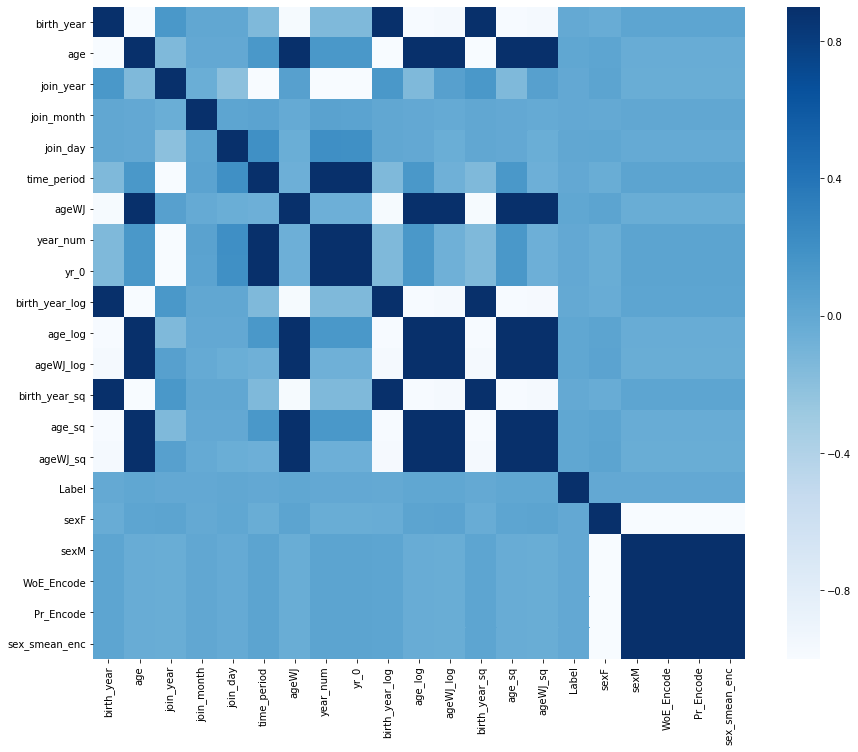

In [60]:
corr = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)